<a href="https://www.kaggle.com/code/yaaangzhou/trial-for-beginners-different-models-and-automl?scriptVersionId=135619484" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/predict-student-performance-from-game-play/sample_submission.csv
/kaggle/input/predict-student-performance-from-game-play/train_labels.csv
/kaggle/input/predict-student-performance-from-game-play/train.csv
/kaggle/input/predict-student-performance-from-game-play/test.csv
/kaggle/input/predict-student-performance-from-game-play/jo_wilder_310/competition.cpython-310-x86_64-linux-gnu.so
/kaggle/input/predict-student-performance-from-game-play/jo_wilder_310/__init__.py
/kaggle/input/predict-student-performance-from-game-play/jo_wilder/competition.cpython-37m-x86_64-linux-gnu.so
/kaggle/input/predict-student-performance-from-game-play/jo_wilder/__init__.py


# Import

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
from plotly.subplots import make_subplots
import plotly.graph_objects as go


from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import OrdinalEncoder
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import train_test_split

from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import roc_auc_score


from xgboost import XGBClassifier
from catboost import CatBoostClassifier
from lightgbm import LGBMClassifier


from matplotlib import ticker
import time
import warnings
warnings.filterwarnings('ignore')


from sklearn.model_selection import KFold, GroupKFold
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import f1_score


from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.models import Sequential,Model
from tensorflow.keras.layers import Dense,Input,Add
from tensorflow.keras.optimizers import Adam
import keras
import tensorflow as tf
from tensorflow.keras.callbacks import EarlyStopping,ReduceLROnPlateau

In [3]:
# this memory reduce solution comes from https://www.kaggle.com/code/cdeotte/xgboost-baseline-0-680

tmp = pd.read_csv("/kaggle/input/predict-student-performance-from-game-play/train.csv",usecols=[0])
tmp = tmp.groupby('session_id').session_id.agg('count')

# COMPUTE READS AND SKIPS
PIECES = 10
CHUNK = int( np.ceil(len(tmp)/PIECES) )

reads = []
skips = [0]
for k in range(PIECES):
    a = k*CHUNK
    b = (k+1)*CHUNK
    if b>len(tmp): b=len(tmp)
    r = tmp.iloc[a:b].sum()
    reads.append(r)
    skips.append(skips[-1]+r)
    
print(f'To avoid memory error, we will read train in {PIECES} pieces of sizes:')
print(reads)

To avoid memory error, we will read train in 10 pieces of sizes:
[2684191, 2631991, 2638304, 2657670, 2644229, 2629801, 2596616, 2602258, 2619995, 2591891]


In [4]:
train = pd.read_csv('/kaggle/input/predict-student-performance-from-game-play/train.csv', nrows=reads[0])
print('Train size of first piece:', train.shape )
train.head()

Train size of first piece: (2684191, 20)


,session_id,index,elapsed_time,event_name,name,level,page,room_coor_x,room_coor_y,screen_coor_x,screen_coor_y,hover_duration,text,fqid,room_fqid,text_fqid,fullscreen,hq,music,level_group
0,20090312431273200,0,0,cutscene_click,basic,0,NaN,-413.991405,-159.314686,380.0,494.0,NaN,undefined,intro,tunic.historicalsociety.closet,tunic.historicalsociety.closet.intro,0,0,1,0-4
1,20090312431273200,1,1323,person_click,basic,0,NaN,-413.991405,-159.314686,380.0,494.0,NaN,"Whatcha doing over there, Jo?",gramps,tunic.historicalsociety.closet,tunic.historicalsociety.closet.gramps.intro_0_...,0,0,1,0-4
2,20090312431273200,2,831,person_click,basic,0,NaN,-413.991405,-159.314686,380.0,494.0,NaN,Just talking to Teddy.,gramps,tunic.historicalsociety.closet,tunic.historicalsociety.closet.gramps.intro_0_...,0,0,1,0-4
3,20090312431273200,3,1147,person_click,basic,0,NaN,-413.991405,-159.314686,380.0,494.0,NaN,I gotta run to my meeting!,gramps,tunic.historicalsociety.closet,tunic.historicalsociety.closet.gramps.intro_0_...,0,0,1,0-4
4,20090312431273200,4,1863,person_click,basic,0,NaN,-412.991405,-159.314686,381.0,494.0,NaN,"Can I come, Gramps?",gramps,tunic.historicalsociety.closet,tunic.historicalsociety.closet.gramps.intro_0_...,0,0,1,0-4


In [5]:
targets = pd.read_csv('/kaggle/input/predict-student-performance-from-game-play/train_labels.csv')
targets.head()

,session_id,correct
0,20090312431273200_q1,1
1,20090312433251036_q1,0
2,20090312455206810_q1,1
3,20090313091715820_q1,0
4,20090313571836404_q1,1


In [6]:
# seprate session_id

targets['session'] = targets.session_id.apply(lambda x: int(x.split('_')[0]) )
targets['q'] = targets.session_id.apply(lambda x: int(x.split('_')[-1][1:]) )
targets.head()

,session_id,correct,session,q
0,20090312431273200_q1,1,20090312431273200,1
1,20090312433251036_q1,0,20090312433251036,1
2,20090312455206810_q1,1,20090312455206810,1
3,20090313091715820_q1,0,20090313091715820,1
4,20090313571836404_q1,1,20090313571836404,1


In [7]:
# summary of train data

def summary(df):
    print(f'data shape: {df.shape}')
    summ = pd.DataFrame(df.dtypes, columns=['data type'])
    summ['#missing'] = df.isnull().sum().values * 100
    summ['%missing'] = df.isnull().sum().values / len(df)
    summ['#unique'] = df.nunique().values
    desc = pd.DataFrame(df.describe(include='all').transpose())
    summ['min'] = desc['min'].values
    summ['max'] = desc['max'].values
    summ['first value'] = df.loc[0].values
    summ['second value'] = df.loc[1].values
    summ['third value'] = df.loc[2].values
    
    return summ

summary_table = summary(train)
summary_table

data shape: (2684191, 20)


,data type,#missing,%missing,#unique,min,max,first value,second value,third value
session_id,int64,0,0.000000,2357,20090312431273200.0,20110316334583480.0,20090312431273200,20090312431273200,20090312431273200
index,int64,0,0.000000,20348,0.0,20473.0,0,1,2
elapsed_time,int64,0,0.000000,1785689,0.0,584384759.0,0,1323,831
event_name,object,0,0.000000,11,NaN,NaN,cutscene_click,person_click,person_click
name,object,0,0.000000,6,NaN,NaN,basic,basic,basic
level,int64,0,0.000000,23,0.0,22.0,0,0,0
page,float64,262482800,0.977884,7,0.0,6.0,NaN,NaN,NaN
room_coor_x,float64,22979600,0.085611,1961769,-1991.219583,1257.35392,-413.991405,-413.991405,-413.991405
room_coor_y,float64,22979600,0.085611,1472156,-916.349865,536.737502,-159.314686,-159.314686,-159.314686
screen_coor_x,float64,22979600,0.085611,11073,0.0,1919.0,380.0,380.0,380.0


# Feature Engineering

In [8]:
train['event_name'].value_counts()

navigate_click        1151606
person_click           606658
cutscene_click         268843
object_click           227641
object_hover           117460
map_hover              105233
notification_click      64639
notebook_click          59363
map_click               53423
observation_click       22222
checkpoint               7103
Name: event_name, dtype: int64

In [9]:
CATS = ['event_name', 'fqid', 'room_fqid', 'text']
NUMS = ['elapsed_time','level','page','room_coor_x', 'room_coor_y', 
        'screen_coor_x', 'screen_coor_y', 'hover_duration']

# https://www.kaggle.com/code/kimtaehun/lightgbm-baseline-with-aggregated-log-data
EVENTS = ['navigate_click','person_click','cutscene_click','object_click',
          'map_hover','notification_click','map_click','observation_click',
          'checkpoint']

In [10]:
def feature_engineer(train):
    '''
    for each group:
    we caculate the number unique of those variable category,
    the mean/std of those variable numeric
    onehot coding for those variable 'events' 
    sum of elapsed time
    imputer missing values
    '''
    dfs = []
    for c in CATS:
        tmp = train.groupby(['session_id','level_group'])[c].agg('nunique')
        tmp.name = tmp.name + '_nunique'
        dfs.append(tmp)
    for c in NUMS:
        tmp = train.groupby(['session_id','level_group'])[c].agg('mean')
        tmp.name = tmp.name + '_mean'
        dfs.append(tmp)
    for c in NUMS:
        tmp = train.groupby(['session_id','level_group'])[c].agg('std')
        tmp.name = tmp.name + '_std'
        dfs.append(tmp)
    for c in EVENTS: 
        train[c] = (train.event_name == c).astype('int8')
    for c in EVENTS + ['elapsed_time']:
        tmp = train.groupby(['session_id','level_group'])[c].agg('sum')
        tmp.name = tmp.name + '_sum'
        dfs.append(tmp)
    train = train.drop(EVENTS,axis=1)
        
    df = pd.concat(dfs,axis=1)
    df = df.fillna(-1)
    df = df.reset_index()
    df = df.set_index('session_id')
    return df

In [11]:
import gc

all_pieces = []
print(f'Processing train as {PIECES} pieces to avoid memory error... ')
for k in range(PIECES):
    print(k,', ',end='')
    SKIPS = 0
    if k>0: SKIPS = range(1,skips[k]+1)
    train = pd.read_csv('/kaggle/input/predict-student-performance-from-game-play/train.csv',
                        nrows=reads[k], skiprows=SKIPS)
    df = feature_engineer(train)
    all_pieces.append(df)
    
# CONCATENATE ALL PIECES
print('\n')
del train; gc.collect()
df = pd.concat(all_pieces, axis=0)
print('Shape of all train data after feature engineering:', df.shape)
df.head()

Processing train as 10 pieces to avoid memory error... 
0 , 1 , 2 , 3 , 4 , 5 , 6 , 7 , 8 , 9 , 

Shape of all train data after feature engineering: (70686, 31)


,level_group,event_name_nunique,fqid_nunique,room_fqid_nunique,text_nunique,elapsed_time_mean,level_mean,page_mean,room_coor_x_mean,room_coor_y_mean,...,navigate_click_sum,person_click_sum,cutscene_click_sum,object_click_sum,map_hover_sum,notification_click_sum,map_click_sum,observation_click_sum,checkpoint_sum,elapsed_time_sum
session_id,,,,,,,,,,,,,,,,,,,,,
20090312431273200,0-4,10,30,7,56,8.579356e+04,1.945455,-1.0,7.701275,-71.413749,...,81,22,28,11,4,8,2,4,1,14155937
20090312431273200,13-22,10,49,12,168,1.040601e+06,17.402381,-1.0,-130.347170,-162.004310,...,170,123,60,20,14,10,6,3,1,437052322
20090312431273200,5-12,10,39,11,124,3.572052e+05,8.054054,-1.0,14.306062,-57.269322,...,103,104,12,28,9,9,8,1,1,105732736
20090312433251036,0-4,11,22,6,49,9.763342e+04,1.870504,0.0,-84.045960,-53.671082,...,49,18,36,15,3,5,3,2,1,13571045
20090312433251036,13-22,11,73,16,183,2.498852e+06,17.762529,5.1,-30.762282,-142.861892,...,637,145,65,83,186,14,45,5,1,3241011333


In [12]:
print(df.shape)

(70686, 31)


In [13]:
FEATURES = [c for c in df.columns if c != 'level_group']
print('We will train with', len(FEATURES) ,'features')
ALL_USERS = df.index.unique()
print('We will train with', len(ALL_USERS) ,'users info')

We will train with 30 features
We will train with 23562 users info


In [14]:
FEATURES

['event_name_nunique',
 'fqid_nunique',
 'room_fqid_nunique',
 'text_nunique',
 'elapsed_time_mean',
 'level_mean',
 'page_mean',
 'room_coor_x_mean',
 'room_coor_y_mean',
 'screen_coor_x_mean',
 'screen_coor_y_mean',
 'hover_duration_mean',
 'elapsed_time_std',
 'level_std',
 'page_std',
 'room_coor_x_std',
 'room_coor_y_std',
 'screen_coor_x_std',
 'screen_coor_y_std',
 'hover_duration_std',
 'navigate_click_sum',
 'person_click_sum',
 'cutscene_click_sum',
 'object_click_sum',
 'map_hover_sum',
 'notification_click_sum',
 'map_click_sum',
 'observation_click_sum',
 'checkpoint_sum',
 'elapsed_time_sum']

# Modeling

Here i'm going to use NN to predict.

## DNN + CV

In [15]:
gkf = GroupKFold(n_splits=5)
oof = pd.DataFrame(data=np.zeros((len(ALL_USERS),18)), index=ALL_USERS)
models = {}

# COMPUTE CV SCORE WITH 5 GROUP K FOLD
for i, (train_index, test_index) in enumerate(gkf.split(X=df, groups=df.index)):
    print('#'*25)
    print('### Fold',i+1)
    print('#'*25)
            
    def build_model():
        input_layer = Input(shape=(len(FEATURES),))
        hidden_layer_1 = Dense(64, activation='relu')(input_layer)
        hidden_layer_2 = Dense(32, activation='relu')(hidden_layer_1)
        hidden_layer_3 = Dense(64, activation='relu')(hidden_layer_2)
        hidden_layer_4 = Dense(32, activation='relu')(hidden_layer_3)
        hidden_layer_5 = Dense(64, activation='relu')(hidden_layer_4)
        hidden_layer_6 = Dense(32, activation='relu')(Add()([hidden_layer_1, hidden_layer_5]))
    #     skip_1 = Add()([hidden_layer_1, hidden_layer_5])
    
        hidden_layer_7 = Dense(64, activation='relu')(hidden_layer_6)
        hidden_layer_8 = Dense(32, activation='relu')(Add()([hidden_layer_3, hidden_layer_7]))
        hidden_layer_9 = Dense(64, activation='relu')(hidden_layer_8)
        hidden_layer_10 = Dense(8, activation='relu')(Add()([hidden_layer_5, hidden_layer_9]))

        skip_4 = Add()([hidden_layer_2, hidden_layer_8])
        output_layer = Dense(1, activation='sigmoid')(skip_4)
        model = Model(inputs=input_layer, outputs=output_layer)
        return model
# Build the model
    model = build_model()
    
    early = EarlyStopping(monitor="val_loss", mode= "min", patience=7)
    
#   learning_rate_reduction = ReduceLROnPlateau(monitor="val_loss", patience =5, verbose=1,factor=0.02,min_learning_rate=0.0001)
    callbacks_list = [early]
    model.compile(optimizer=Adam(learning_rate=0.05), loss='binary_crossentropy',metrics=['accuracy'])

    # ITERATE THROUGH QUESTIONS 1 THRU 18
    for t in range(1, 19):

        # USE THIS TRAIN DATA WITH THESE QUESTIONS
        if t <= 3:
            grp = '0-4'
        elif t <= 13:
            grp = '5-12'
        elif t <= 22:
            grp = '13-22'

        # TRAIN DATA
        train_x = df.iloc[train_index]
        train_x = train_x.loc[train_x.level_group == grp]
        train_users = train_x.index.values
        train_y = targets.loc[targets.q == t].set_index('session').loc[train_users]
        
        # VALID DATA
        valid_x = df.iloc[test_index]
        valid_x = valid_x.loc[valid_x.level_group == grp]
        valid_users = valid_x.index.values
        valid_y = targets.loc[targets.q == t].set_index('session').loc[valid_users]

        # CONVERT LABELS TO NUMERIC
        label_encoder = LabelEncoder()
        train_y_encoded = label_encoder.fit_transform(train_y['correct'])
        valid_y_encoded = label_encoder.transform(valid_y['correct'])

        # TRAIN MODEL
        
        
        model.fit(train_x[FEATURES].astype('float32'), train_y_encoded,
                  validation_data=(valid_x[FEATURES].astype('float32'), valid_y_encoded),
                  epochs=5,callbacks= callbacks_list)

        # SAVE MODEL, PREDICT VALID OOF
        models[f'{grp}_{t}'] = model
        oof.loc[valid_users, t - 1] = model.predict(valid_x[FEATURES].astype('float32'))[:, 0]

        print()

#########################
### Fold 1
#########################
Epoch 1/5
590/590 [==============================] - 3s 3ms/step - loss: 39702.0117 - accuracy: 0.7165 - val_loss: 0.6029 - val_accuracy: 0.7187
Epoch 2/5
590/590 [==============================] - 1s 2ms/step - loss: 0.5858 - accuracy: 0.7297 - val_loss: 0.5952 - val_accuracy: 0.7187
Epoch 3/5
590/590 [==============================] - 1s 2ms/step - loss: 0.5861 - accuracy: 0.7297 - val_loss: 0.6071 - val_accuracy: 0.7187
Epoch 4/5
590/590 [==============================] - 1s 2ms/step - loss: 0.5867 - accuracy: 0.7297 - val_loss: 0.5942 - val_accuracy: 0.7187
Epoch 5/5
148/148 [==============================] - 0s 1ms/step

Epoch 1/5
590/590 [==============================] - 1s 3ms/step - loss: 0.1048 - accuracy: 0.9794 - val_loss: 0.1116 - val_accuracy: 0.9764
Epoch 2/5
590/590 [==============================] - 1s 2ms/step - loss: 0.1009 - accuracy: 0.9794 - val_loss: 0.1118 - val_accuracy: 0.9764
Epoch 3/5
590/590 [==

In [16]:
# PUT TRUE LABELS INTO DATAFRAME WITH 18 COLUMNS
true = oof.copy()
for k in range(18):
    # GET TRUE LABELS
    tmp = targets.loc[targets.q == k+1].set_index('session').loc[ALL_USERS]
    true[k] = tmp.correct.values

In [17]:
oof

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17
session_id,,,,,,,,,,,,,,,,,,
20090312431273200,0.742242,0.981474,0.945845,0.790277,0.530704,0.779802,0.770479,0.575412,0.737089,0.466731,0.638657,0.872899,0.285959,0.715845,0.480361,0.748628,0.689505,0.950568
20090312433251036,0.714615,0.992421,0.948170,0.726318,0.563449,0.794794,0.753597,0.638680,0.724400,0.471911,0.647834,0.843239,0.289967,0.718106,0.455316,0.741711,0.667183,0.960362
20090312455206810,0.742242,0.981474,0.945845,0.790277,0.530704,0.779802,0.770479,0.575412,0.737089,0.466731,0.638657,0.872899,0.285959,0.715845,0.480361,0.748628,0.689505,0.950568
20090313091715820,0.743033,0.974886,0.942166,0.768009,0.620101,0.795277,0.705229,0.576781,0.742628,0.507997,0.590502,0.868649,0.253904,0.684081,0.511758,0.741819,0.700760,0.950479
20090313571836404,0.742673,0.974565,0.932671,0.792732,0.598505,0.805543,0.746341,0.617271,0.731947,0.484023,0.659080,0.841996,0.247795,0.719155,0.508219,0.717233,0.668249,0.955080
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
22100215342220508,0.742673,0.974565,0.932671,0.792732,0.598505,0.805543,0.746341,0.617271,0.731947,0.484023,0.659080,0.841996,0.247795,0.719155,0.508219,0.717233,0.668249,0.955080
22100215460321130,0.682406,0.978637,0.939687,0.773409,0.548183,0.742538,0.748054,0.614322,0.722178,0.482802,0.649231,0.843423,0.283614,0.691506,0.462871,0.701718,0.701035,0.946683
22100217104993650,0.714615,0.992421,0.948170,0.726318,0.563449,0.794794,0.753597,0.638680,0.724400,0.471911,0.647834,0.843239,0.289967,0.718106,0.455316,0.741711,0.667183,0.960362


In [18]:
oof.values.reshape((-1))

array([0.7422421 , 0.98147428, 0.94584543, ..., 0.74171078, 0.66718346,
       0.96036178])

In [19]:
# FIND BEST THRESHOLD TO CONVERT PROBS INTO 1s AND 0s
scores= []
thresholds = []
best_score =0
best_thresh=0

for thresh in np.arange(0.3,0.9,0.01):
    print(f'{thresh}, ',end='')
    preds = (oof.values.reshape((-1))>thresh).astype('int')
    m = f1_score(true.values.reshape((-1)), preds, average='macro')  
    scores.append(m)
    thresholds.append(thresh)
    if m>best_score:
        best_score = m
        best_thresh = thresh

0.3, 0.31, 0.32, 0.33, 0.34, 0.35000000000000003, 0.36000000000000004, 0.37000000000000005, 0.38000000000000006, 0.39000000000000007, 0.4000000000000001, 0.4100000000000001, 0.4200000000000001, 0.4300000000000001, 0.4400000000000001, 0.4500000000000001, 0.46000000000000013, 0.47000000000000014, 0.48000000000000015, 0.49000000000000016, 0.5000000000000002, 0.5100000000000002, 0.5200000000000002, 0.5300000000000002, 0.5400000000000003, 0.5500000000000003, 0.5600000000000003, 0.5700000000000003, 0.5800000000000003, 0.5900000000000003, 0.6000000000000003, 0.6100000000000003, 0.6200000000000003, 0.6300000000000003, 0.6400000000000003, 0.6500000000000004, 0.6600000000000004, 0.6700000000000004, 0.6800000000000004, 0.6900000000000004, 0.7000000000000004, 0.7100000000000004, 0.7200000000000004, 0.7300000000000004, 0.7400000000000004, 0.7500000000000004, 0.7600000000000005, 0.7700000000000005, 0.7800000000000005, 0.7900000000000005, 0.8000000000000005, 0.8100000000000005, 0.8200000000000005, 0.

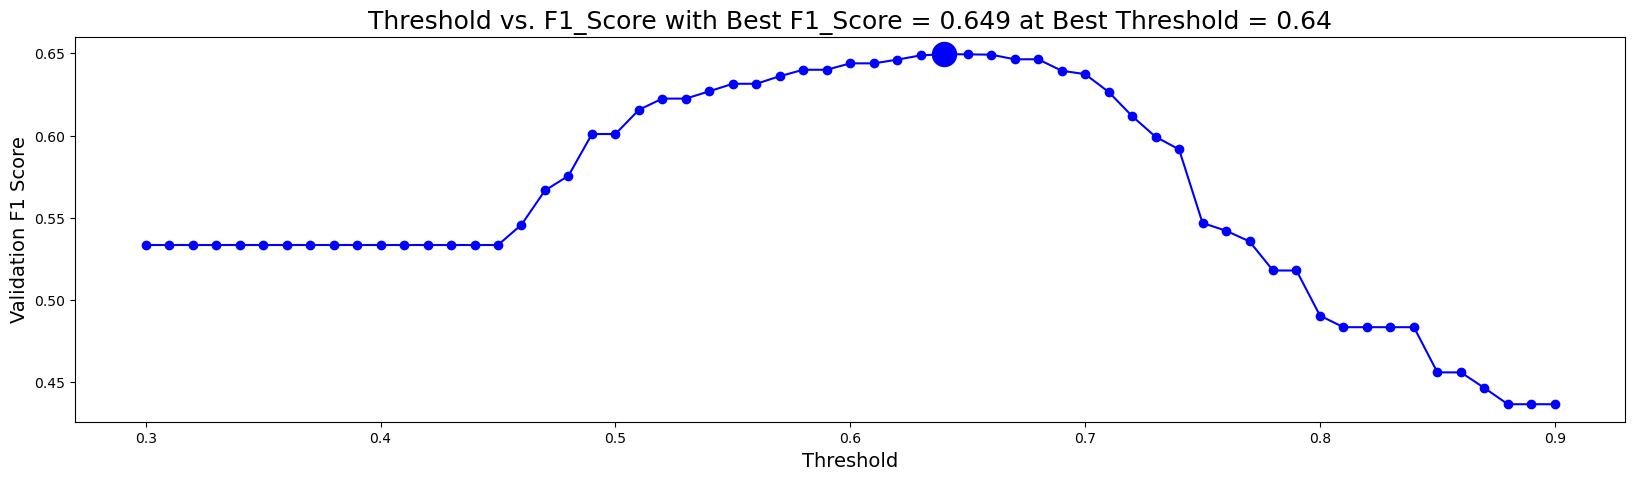

In [20]:
import matplotlib.pyplot as plt

# PLOT THRESHOLD VS. F1_SCORE
plt.figure(figsize=(20,5))
plt.plot(thresholds,scores,'-o',color='blue')
plt.scatter([best_thresh], [best_score], color='blue', s=300, alpha=1)
plt.xlabel('Threshold',size=14)
plt.ylabel('Validation F1 Score',size=14)
plt.title(f'Threshold vs. F1_Score with Best F1_Score = {best_score:.3f} at Best Threshold = {best_thresh:.3}',size=18)
plt.show()